Notebook used to generate figure 4A

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import BootstrapFunctions as bsf
from matplotlib.font_manager import FontProperties
from scipy.interpolate import interp1d

ibm_pal_rb = sns.blend_palette(['#648fff','#785ef0','#dc267f',],as_cmap=True)
ibm_full_list = ['#648fff','#785ef0','#dc267f','#fe6100','#ffb000','#000000','#ffffff']
category_palette = sns.color_palette(['#648fff','#785ef0','#dc267f',],as_cmap=True)

In [2]:
sns.color_palette(ibm_full_list)

[(0.39215686274509803, 0.5607843137254902, 1.0),
 (0.47058823529411764, 0.3686274509803922, 0.9411764705882353),
 (0.8627450980392157, 0.14901960784313725, 0.4980392156862745),
 (0.996078431372549, 0.3803921568627451, 0.0),
 (1.0, 0.6901960784313725, 0.0),
 (0.0, 0.0, 0.0),
 (1.0, 1.0, 1.0)]

In [3]:
fontpath = '/Users/seshu/Library/Fonts/TorontoSubwayLight.otf'
labelfont = FontProperties(fname=fontpath,size=15)

In [4]:
def rate(y,Kneg,Kpos,l,offset):
    return l*(y/(Kpos+y))*(Kneg/(Kneg+y))+offset
def rate_deriv(y,Kneg,Kpos,l,offset):
    return -1*l*Kneg*(y**2-Kneg*Kpos)/((Kneg + y)**2*(Kpos + y)**2)
def sensitivity(y,Kneg,Kpos,l,offset):
    return (y/rate(y,Kneg,Kpos,l,offset))*rate_deriv(y,Kneg,Kpos,l,offset)

In [5]:
def lin_eta_xx(eta_ll,eta_gg,fy,fx):
    return (eta_ll + eta_gg*fy**2)/(1-fy-fx)**2
def lin_eta_yy(eta_ll,eta_gg,fy,fx):
    return (eta_ll + eta_gg*(1-fx)**2)/(1-fy-fx)**2
def lin_eta_xy(eta_ll,eta_gg,fy,fx):
    return (eta_ll + eta_gg*(1-fx)*fy)/(1-fy-fx)**2
def lin_rho(eta_ll,eta_gg,fy,fx):
    return lin_eta_xy(eta_ll,eta_gg,fy,fx)/np.sqrt(lin_eta_xx(eta_ll,eta_gg,fy,fx)*lin_eta_yy(eta_ll,eta_gg,fy,fx))
def lin_CVratio(eta_ll,eta_gg,fy,fx):
    return np.sqrt(lin_eta_xx(eta_ll,eta_gg,fy,fx)/lin_eta_yy(eta_ll,eta_gg,fy,fx))

In [6]:
ibm_pal_rb = sns.blend_palette(['#648fff','#ffffff','#dc267f',],as_cmap=True)

In [7]:
paramlist = ['lambda','beta_x','gamma','beta_y','Kpos','Kneg','offset']
byfilelist = ['fileN','fileda','filedb','sysname']

In [8]:
#List out the perturbation types: u is up, d is down, n is none. l for lambda, g for gamma.  Add 1,2 to balance the neutral points
pertcases = {"lngn":[0,1,2],"lngu":[3,4,5],"lngd":[6,7,8],
             "lugn":[9,10,11],"lugu":[12,13,14],"lugd":[15,16,17],
             "ldgn":[18,19,20],"ldgu":[21,22,23],"ldgd":[24,25,26]}
oneparamperts = pertcases["lngn"]+pertcases["lugn"]+pertcases["ldgn"]+pertcases["lngu"]+pertcases["lngd"]
no_nonperts = pertcases["lugn"]+pertcases["ldgn"]+pertcases["lngu"]+pertcases["lngd"]

In [9]:
folders = glob.glob('Data/andgate_withdist/*/*')
dat = []
pdists = {}
failedsims = []
bootstrapdicts = []
for i,folder in enumerate(folders):
    files = glob.glob(folder+'/*data.csv',recursive=True)
    for j,f in enumerate(files):
        data = pd.read_csv(f)
        data = data.reset_index().rename(columns={'index':'perturbation'})
        numstrings = f.split("_")[-2].split('n')
        data['fileN'] = float(numstrings[0])
        data['fileda'] = float(numstrings[1])
        data['filedb'] = float(numstrings[2])
        data['sysname'] = "/".join(f.split("/")[:-1])
        data['<F_x>'] = 0
        if (data[['Cov Bal xx','Cov Bal yy','Cov Bal xy']] > 0.05).any(axis=1).any():
            failedsims.append(f)
            continue
        dat.append(data)
        bsdict = bsf.pertexp_interpret(data,20000,analysed_columns=['<x>','<y>','<F_x>','<F_y>'])
        fy = sensitivity(data['<y>'],data['Kneg'],data['Kpos'],data['lambda'],data['offset'])
        bsdict['avg fy'] = fy.mean()
        bsdict['fileN'] = float(numstrings[0])
        bsdict['fileda'] = float(numstrings[1])
        bsdict['filedb'] = float(numstrings[2])
        bsdict['sysname'] = "/".join(f.split("/")[:-1])
        bsdict['consistent fy count'] = np.sum(np.sign(fy))
        for p in paramlist:
            bsdict[p] = data[p][0]
        bootstrapdicts.append(bsdict)
    pdistfiles = glob.glob(folder+'/*pdist.csv',recursive=True)
    for j,f in enumerate(pdistfiles):
        data = pd.read_csv(f)
        numstrings = f.split("_")[3:]
        data['fileda'] = float(f.split("da_")[1].split("_db_")[0])
        data['filedb'] = float(f.split("da_")[1].split("_db_")[1].split("_")[0])
        data['sysname'] = f.split("da_")[0]
        data['perturbation'] = int(f.split("_")[-2])
        pdists[(data['fileda'][0],data['filedb'][0],data['sysname'][0],data['perturbation'][0])] = data
analysed_data = pd.concat(dat)

analysed_data = analysed_data[(analysed_data["filedb"]>=0.005)&(analysed_data["fileda"]>=0.005)]
bootstrapped_res_tot = pd.DataFrame(bootstrapdicts)
bootstrapped_res_tot.set_index(["fileN",'fileda','filedb','sysname'],inplace=True)
pertdata = analysed_data.set_index(["fileN",'fileda','filedb','sysname','perturbation'])
pertdata['offset'] = pertdata['offset'].fillna(0)

In [10]:
f.split("_")

['Data/andgate',
 'withdist/07-11 0957/system',
 '0/da',
 '9.441e-02',
 'db',
 '3.126e-01',
 'sys',
 '0',
 'pert',
 '14',
 'pdist.csv']

In [11]:
curated = ((bootstrapped_res_tot['consistent fy count'] == -27) | ((bootstrapped_res_tot['consistent fy count'] == 27)| (bootstrapped_res_tot['consistent fy count'] == 0)))

In [12]:
bootstrapped_res = bootstrapped_res_tot[curated]

In [13]:
not_curated = bootstrapped_res_tot[~curated]

In [14]:
bootstrapped_res['consistent fy count']

fileN    fileda   filedb   sysname                                  
1.122    0.09441  0.10000  Data/andgate_withdist/07-11 1030/system_2    27.0
100.000  0.01000  0.10000  Data/andgate_withdist/07-11 1030/system_2    27.0
1.122    0.09441  0.10000  Data/andgate_withdist/07-11 1030/system_5    27.0
977.200  0.01000  0.31260  Data/andgate_withdist/07-11 1030/system_5    27.0
10.960   0.09441  0.31260  Data/andgate_withdist/07-11 1030/system_5    27.0
                                                                        ... 
6.813    0.02154  0.05623  Data/andgate_withdist/07-17 1358/system_0    27.0
100.000  0.01000  0.10000  Data/andgate_withdist/07-11 0957/system_0   -27.0
10.960   0.09441  0.31260  Data/andgate_withdist/07-11 0957/system_0   -27.0
1.122    0.09441  0.10000  Data/andgate_withdist/07-11 0957/system_0   -27.0
977.200  0.01000  0.31260  Data/andgate_withdist/07-11 0957/system_0   -27.0
Name: consistent fy count, Length: 400, dtype: float64

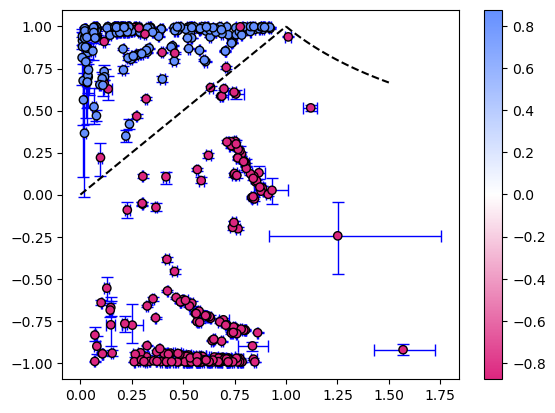

In [15]:
plt.errorbar(bootstrapped_res['E[CVx/CVy]'],bootstrapped_res['E[rhoxy]'],
             xerr=bsf.CV_bars(bootstrapped_res),
             yerr=bsf.rho_bars(bootstrapped_res),
             capsize=4,fmt='None',zorder=-1,elinewidth=1,c='b')

plt.scatter(bootstrapped_res['E[CVx/CVy]'],bootstrapped_res['E[rhoxy]'],
            c=np.sign(bootstrapped_res['E[<F_y>]']),
            edgecolors='k',cmap=ibm_pal_rb.reversed(),
            vmin=bootstrapped_res['avg fy'].min(),
            vmax=-1*bootstrapped_res['avg fy'].min())
plt.plot(np.linspace(0,1),np.linspace(0,1),'k--')
plt.plot(np.linspace(1,1.5),1/np.linspace(1,1.5),'k--')
plt.colorbar()

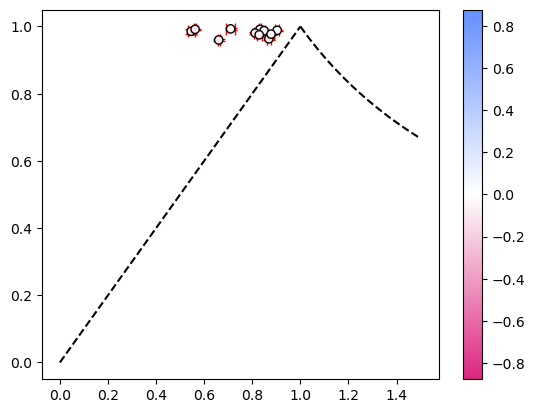

In [16]:
plt.errorbar(not_curated['E[CVx/CVy]'],not_curated['E[rhoxy]'],
                xerr=bsf.CV_bars(not_curated),
                yerr=bsf.rho_bars(not_curated),
                capsize=4,fmt='None',zorder=-1,elinewidth=1,c='r')
plt.scatter(not_curated['E[CVx/CVy]'],not_curated['E[rhoxy]'],
            c=(not_curated['E[<F_y>]']),
            edgecolors='k',cmap=ibm_pal_rb.reversed(),
            vmin=bootstrapped_res['avg fy'].min(),
            vmax=-1*bootstrapped_res['avg fy'].min())
plt.colorbar()
plt.plot(np.linspace(0,1),np.linspace(0,1),'k--')
plt.plot(np.linspace(1,1.5),1/np.linspace(1,1.5),'k--')

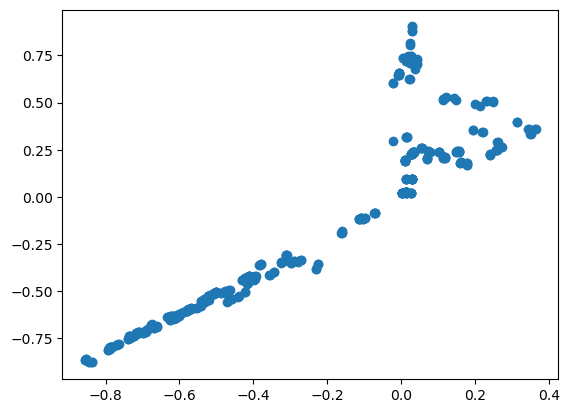

In [17]:
plt.scatter(bootstrapped_res['E[<F_y>]'],bootstrapped_res['avg fy'])


In [18]:
mean_above_line = (bootstrapped_res['E[rhoxy]'] > bootstrapped_res['E[CVx/CVy]'])
mean_below_line = (bootstrapped_res['E[rhoxy]'] < bootstrapped_res['E[CVx/CVy]'])
minrho_above_line = (bootstrapped_res['2.5% (rhoxy)'] > bootstrapped_res['E[CVx/CVy]'])
minrho_below_line = (bootstrapped_res['2.5% (rhoxy)'] < bootstrapped_res['E[CVx/CVy]'])
maxrho_above_line = (bootstrapped_res['97.5% (rhoxy)'] > bootstrapped_res['E[CVx/CVy]'])
maxrho_below_line = (bootstrapped_res['97.5% (rhoxy)'] < bootstrapped_res['E[CVx/CVy]'])
mincv_above_line = (bootstrapped_res['E[rhoxy]'] > bootstrapped_res['2.5% (CVx/CVy)'])
mincv_below_line = (bootstrapped_res['E[rhoxy]'] < bootstrapped_res['2.5% (CVx/CVy)'])
maxcv_above_line = (bootstrapped_res['E[rhoxy]'] > bootstrapped_res['97.5% (CVx/CVy)'])
maxcv_below_line = (bootstrapped_res['E[rhoxy]'] < bootstrapped_res['97.5% (CVx/CVy)'])
negative_fy = (bootstrapped_res['E[<F_y>]'] < 0)
positive_fy = (bootstrapped_res['E[<F_y>]'] > 0)


In [19]:
violators_above_line = bootstrapped_res[negative_fy&~(minrho_below_line|maxcv_below_line)]
violators_below_line = bootstrapped_res[positive_fy&maxrho_below_line&mincv_below_line]

In [20]:
np.logspace(-3,3,10)

array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])

In [21]:
bootstrapped_res[(bootstrapped_res['avg fy']>0)&(bootstrapped_res['E[rhoxy]']<bootstrapped_res['E[CVx/CVy]'])]

,,,,E[rhoxy],2.5% (rhoxy),50% (rhoxy),97.5% (rhoxy),E[CVx/CVy],2.5% (CVx/CVy),50% (CVx/CVy),97.5% (CVx/CVy),E[<x>],E[<y>],...,97.5% (theta_calc),avg fy,consistent fy count,lambda,beta_x,gamma,beta_y,Kpos,Kneg,offset
fileN,fileda,filedb,sysname,,,,,,,,,,,,,,,,,,,,,
177.800,0.01000,0.13340,Data/andgate_withdist/07-17 1358/system_0,-0.899392,-0.928932,-0.897482,-0.875211,0.836919,0.768174,0.83746,0.913200,0.049098,0.244176,...,-0.026982,0.603877,27.0,10.0,1.0,50.0,10.0,1.0,1,0.01
6.813,0.02154,0.05623,Data/andgate_withdist/07-17 1358/system_0,0.025851,-0.058047,0.027567,0.099142,0.931727,0.844194,0.93376,1.008586,0.048982,0.244681,...,-0.027053,0.603081,27.0,10.0,1.0,50.0,10.0,1.0,1,0.01


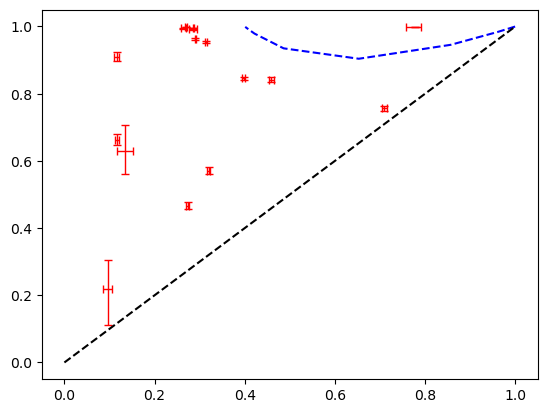

In [22]:
plt.errorbar(violators_above_line['E[CVx/CVy]'],violators_above_line['E[rhoxy]'],
             xerr=bsf.CV_bars(violators_above_line),
             yerr=bsf.rho_bars(violators_above_line),
             capsize=3,fmt='None',zorder=-1,elinewidth=1,c='r')
plt.plot((np.sqrt((1+(0.4**2)*np.logspace(-3,3,10))/((1+np.logspace(-3,3,10))))),
         (1+0.4*np.logspace(-3,3,10))/np.sqrt((1+np.logspace(-3,3,10))*(1+(0.4**2)*np.logspace(-3,3,10))),
         'b--')
plt.plot(np.linspace(0,1),np.linspace(0,1),'k--')

In [23]:
violators_above_line[['avg fy','E[<F_y>]',"E[CVx/CVy]","E[rhoxy]"]]

,,,,avg fy,E[<F_y>],E[CVx/CVy],E[rhoxy]
fileN,fileda,filedb,sysname,,,,
1.122,0.09441,0.1000,Data/andgate_withdist/07-10 1738/system_63,0.657213,-0.007003,0.397634,0.845342
977.200,0.01000,0.3126,Data/andgate_withdist/07-10 1738/system_63,0.645590,-0.007250,0.269911,0.997764
100.000,0.01000,0.1000,Data/andgate_withdist/07-10 1738/system_63,0.658306,-0.007005,0.264102,0.994320
10.960,0.09441,0.3126,Data/andgate_withdist/07-10 1738/system_63,0.644470,-0.007263,0.290280,0.963184
1.122,0.09441,0.1000,Data/andgate_withdist/07-10 1738/system_36,-0.379525,-0.230357,0.709444,0.756320
100.000,0.01000,0.1000,Data/andgate_withdist/07-10 1738/system_36,-0.380992,-0.230176,0.135115,0.628604
977.200,0.01000,0.3126,Data/andgate_withdist/07-10 1738/system_36,-0.356936,-0.224583,0.115775,0.910101
10.960,0.09441,0.3126,Data/andgate_withdist/07-10 1738/system_36,-0.355678,-0.224769,0.319943,0.569387
100.000,0.01000,0.1000,Data/andgate_withdist/07-10 1738/system_54,-0.529239,-0.440536,0.097782,0.220163


In [24]:
bootstrapped_res[(np.sign(bootstrapped_res['avg fy']) != np.sign(bootstrapped_res['E[<F_y>]']))]

E[rhoxy]  \
fileN   fileda  filedb  sysname                                                
1.122   0.09441 0.10000 Data/andgate_withdist/07-10 1738/system_63  0.845342   
977.200 0.01000 0.31260 Data/andgate_withdist/07-10 1738/system_63  0.997764   
100.000 0.01000 0.10000 Data/andgate_withdist/07-10 1738/system_63  0.994320   
10.960  0.09441 0.31260 Data/andgate_withdist/07-10 1738/system_63  0.963184   
                        Data/andgate_withdist/07-10 1738/system_45  0.954742   
977.200 0.01000 0.31260 Data/andgate_withdist/07-10 1738/system_45  0.996324   
100.000 0.01000 0.10000 Data/andgate_withdist/07-10 1738/system_45  0.991451   
1.122   0.09441 0.10000 Data/andgate_withdist/07-10 1738/system_45  0.841212   
100.000 0.01000 0.10000 Data/andgate_withdist/07-11 1047/system_4   0.998007   
177.800 0.01000 0.13340 Data/andgate_withdist/07-17 1358/system_0  -0.899392   
6.813   0.02154 0.05623 Data/andgate_withdist/07-17 1358/system_0   0.025851   

                                                                    2.5% (rhoxy)  \
fileN   fileda  filedb  sysname                                                    
1.122   0.09441 0.10000 Data/andgate_withdist/07-10 1738/system_63      0.840392   
977.200 0.01000 0.31260 Data/andgate_withdist/07-10 1738/system_63      0.997017   
100.000 0.01000 0.10000 Data/andgate_withdist/07-10 1738/system_63      0.992274   
10.960  0.09441 0.31260 Data/andgate_withdist/07-10 1738/system_63      0.961010   
                        Data/andgate_withdist/07-10 1738/system_45      0.952174   
977.200 0.01000 0.31260 Data/andgate_withdist/07-10 1738/system_45      0.995703   
100.000 0.01000 0.10000 Data/andgate_withdist/07-10 1738/system_45      0.988153   
1.122   0.09441 0.10000 Data/andgate_withdist/07-10 1738/system_45      0.834992   
100.000 0.01000 0.10000 Data/andgate_withdist/07-11 1047/system_4       0.997124   
177.800 0.01000 0.13340 Data/andgate_withdist/07-17 1358/system_0      -0.928932   
6.813   0.02154 0.05623 Data/andgate_withdist/07-17 1358/system_0      -0.058047   

                                                                    50% (rhoxy)  \
fileN   fileda  filedb  sysname                                                   
1.122   0.09441 0.10000 Data/andgate_withdist/07-10 1738/system_63     0.845404   
977.200 0.01000 0.31260 Data/andgate_withdist/07-10 1738/system_63     0.997751   
100.000 0.01000 0.10000 Data/andgate_withdist/07-10 1738/system_63     0.994320   
10.960  0.09441 0.31260 Data/andgate_withdist/07-10 1738/system_63     0.963291   
                        Data/andgate_withdist/07-10 1738/system_45     0.954684   
977.200 0.01000 0.31260 Data/andgate_withdist/07-10 1738/system_45     0.996337   
100.000 0.01000 0.10000 Data/andgate_withdist/07-10 1738/system_45     0.991460   
1.122   0.09441 0.10000 Data/andgate_withdist/07-10 1738/system_45     0.840962   
100.000 0.01000 0.10000 Data/andgate_withdist/07-11 1047/system_4      0.997994   
177.800 0.01000 0.13340 Data/andgate_withdist/07-17 1358/system_0     -0.897482   
6.813   0.02154 0.05623 Data/andgate_withdist/07-17 1358/system_0      0.027567   

                                                                    97.5% (rhoxy)  \
fileN   fileda  filedb  sysname                                                     
1.122   0.09441 0.10000 Data/andgate_withdist/07-10 1738/system_63       0.850025   
977.200 0.01000 0.31260 Data/andgate_withdist/07-10 1738/system_63       0.998609   
100.000 0.01000 0.10000 Data/andgate_withdist/07-10 1738/system_63       0.996327   
10.960  0.09441 0.31260 Data/andgate_withdist/07-10 1738/system_63       0.965145   
                        Data/andgate_withdist/07-10 1738/system_45       0.957451   
977.200 0.01000 0.31260 Data/andgate_withdist/07-10 1738/system_45       0.996813   
100.000 0.01000 0.10000 Data/andgate_withdist/07-10 1738/system_45       0.994669   
1.122   0.09441 0.10000 Data/andgate_withdist/07-10 1738/system_45       0.848448   
100.

In [48]:
list(pdists.keys())[0]

(np.float64(0.01),
 np.float64(0.3126),
 'Data/andgate_withdist/07-11 1030/system_2/',
 np.int64(20))

In [26]:
idx = pd.IndexSlice
s = 'Data/andgate_withdist/07-11 1047/system_4'
da = 0.01000
db = 0.1
pert = 0
ex = pdists[(np.float64(da), np.float64(db), s+'/', np.int64(0))]
pars = bootstrapped_res.loc[idx[:,da,db,s]]
print(pars[['Kneg','Kpos','lambda','offset']])
print(pars['E[<F_y>]'])
print(pars['avg fy'])


       Kneg  Kpos  lambda  offset
fileN                            
100.0    10  10.0     5.0   0.001
fileN
100.0   -0.021902
Name: E[<F_y>], dtype: float64
fileN
100.0    0.295554
Name: avg fy, dtype: float64


(0.0, 30.0)

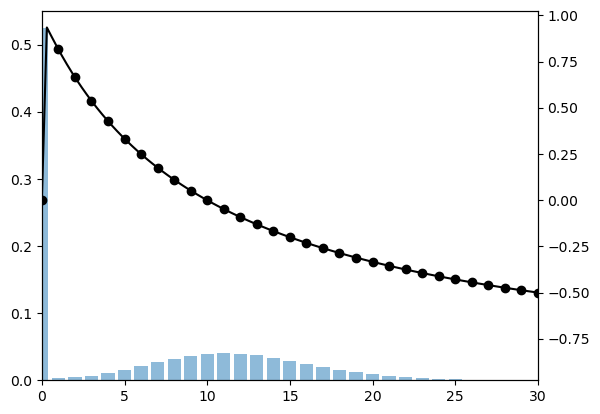

In [27]:
domain = ex['y'].sort_values().unique()[:-1]
plotwindow = [0,30]
contdomain = np.linspace(plotwindow[0],plotwindow[1],100)
plt.bar(ex['y'].sort_values().unique(),ex.groupby('y')[['p']].sum()['p'],alpha=0.5)
plt.twinx()
plt.scatter(domain,
         sensitivity(domain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),marker='o',c='k')
plt.plot(contdomain,
            sensitivity(contdomain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),c='k')
plt.xlim(plotwindow)



In [28]:
ex.groupby('y')[['p']].sum()['p']

y
0      5.244456e-01
1      3.007339e-03
2      4.270965e-03
3      6.929586e-03
4      1.058290e-02
           ...     
163    8.818704e-09
164    7.208174e-08
165    4.668458e-08
166    3.257210e-08
167    3.299947e-08
Name: p, Length: 168, dtype: float64

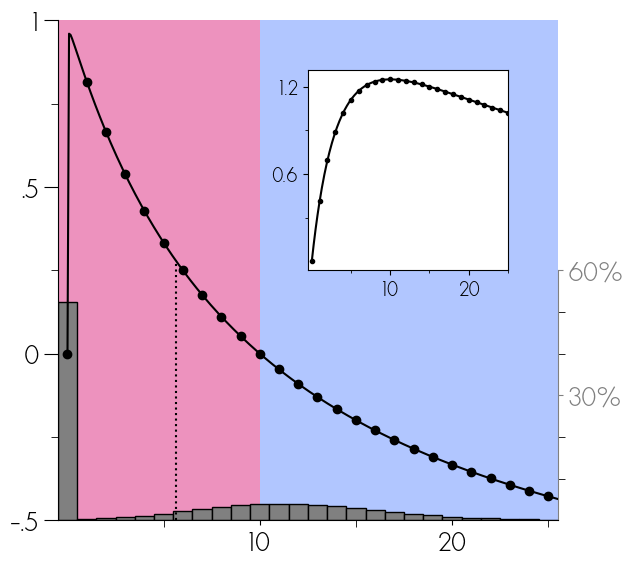

In [29]:
marginal_y = ex.groupby('y')[['p']].sum().reset_index()
pdist = ex
domain = ex['y'].sort_values().unique()[:-1]
contdomain = np.linspace(0,40,500)
avg_y = np.sum(marginal_y['y']*marginal_y['p'])

fig = plt.figure(figsize=(5,5))


ax_pdist = fig.add_axes([0,0,1,0.5],)
ax_pdist.yaxis.tick_right()
ax_pdist.spines['top'].set_visible(False)
ax_pdist.spines['left'].set_visible(False)

ax_pdist.spines['right'].set_color('grey')
ax_pdist.tick_params(axis='y',which='major',color='grey',labelcolor='grey')
ax_pdist.tick_params(axis='y',which='minor',length=5)
ax_pdist.tick_params(axis='x', which='minor',length=5)
ax_pdist.set_xlim(-0.5,25.5)
ax_pdist.set_ylim(0,0.6)


ax_sens = fig.add_axes([0,-0,1,1],facecolor=(0,0,0,0))
ax_sens.yaxis.tick_left()
ax_sens.spines['top'].set_visible(False)
ax_sens.spines['right'].set_visible(False)
ax_sens.spines['bottom'].set_visible(False)
ax_sens.tick_params(axis='x', which='both', labelbottom=False,length=0)
ax_sens.tick_params(axis='y',which='major',length=10)
ax_sens.tick_params(axis='y',which='minor',length=5)
ax_sens.set_xlim(-0.5,25.5)
ax_sens.set_ylim(-0.5,1)
ax_sens.scatter(domain,
         sensitivity(domain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),marker='o',c='k')
ax_sens.plot(contdomain,
            sensitivity(contdomain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),linestyle='-',c='k')
inset_rate_ax = ax_sens.inset_axes([0.5,0.5,0.4,0.4])
inset_rate_ax.set_xlim(-0.5,25)
inset_rate_ax.plot(contdomain,
            rate(contdomain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),c='k')
inset_rate_ax.scatter(domain,
            rate(domain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),marker='.',c='k')

ax_pdist.bar(marginal_y['y'],marginal_y['p'],color='grey',edgecolor='k',
           label=f'perturbation {i}',align='center',width=1)


ax_sens.vlines(avg_y,-0.5,sensitivity(avg_y,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),linestyle=':',color='k')
ax_pdist.fill_between(np.linspace(-0.5,np.sqrt(pars['Kpos'].iloc[0]*pars['Kneg'].iloc[0]),100),
                     -0.5,1.2,facecolor='#dc267f',alpha=0.5,zorder=-10)
ax_pdist.fill_between(np.linspace(np.sqrt(pars['Kpos'].iloc[0]*pars['Kneg'].iloc[0]),25.5,100),
                        -0.5,1.2,facecolor='#648fff',alpha=0.5,zorder=-10)
ax_sens.fill_between(np.linspace(-0.5,np.sqrt(pars['Kpos'].iloc[0]*pars['Kneg'].iloc[0]),100),
                        0.25,1,facecolor='#dc267f',alpha=0.5,zorder=-10)
ax_sens.fill_between(np.linspace(np.sqrt(pars['Kpos'].iloc[0]*pars['Kneg'].iloc[0]),25.5,100),
                        0.25,1,facecolor='#648fff',alpha=0.5,zorder=-10)

ax_sens.set_yticks([-0.5,0,0.5,1])
ax_sens.set_yticks([-0.25,0.25,0.75],minor=True)
ax_sens.set_yticklabels(['-.5','0','.5','1'])

ax_pdist.set_yticks([0.3,0.6])
ax_pdist.set_yticks([0.1,0.2,0.4,0.5],minor=True)
ax_pdist.set_yticklabels([r'30%',r'60%'])

inset_rate_ax.set_xticks([10,20])
inset_rate_ax.set_xticks([5,15,20,25],minor=True)
inset_rate_ax.set_yticks([0.6,1.2])
inset_rate_ax.set_yticks([0.3,0.9],minor=True)

ax_pdist.set_xticks([10,20])
ax_pdist.set_xticks([5,15,20,25],minor=True)
ax_pdist.set_xticklabels([r'10',r'20'])

for tick in ax_pdist.get_xticklabels():
    tick.set_fontproperties(labelfont)
for tick in ax_pdist.get_yticklabels():
    tick.set_fontproperties(labelfont)
for tick in ax_sens.get_yticklabels():
    tick.set_fontproperties(labelfont)
for tick in inset_rate_ax.get_xticklabels():
    tick.set_fontproperties(labelfont)
for tick in inset_rate_ax.get_yticklabels():
    tick.set_fontproperties(labelfont)

ax_pdist.tick_params(axis='both', which='major', labelsize=20)
ax_sens.tick_params(axis='both', which='major', labelsize=20)

#ax_pdist.set_ylabel('Probability Density',color='grey')
#ax_sens.set_ylabel(r'Sensitivity $1-f_x$',color='k')
ax_pdist.yaxis.set_label_position('right')
#ax_pdist.set_xlabel('mRNA abundance')
#fig.savefig('figures/July4/AndGate_ambiguous_sens.pdf',bbox_inches='tight')

(0.98, 1.0)

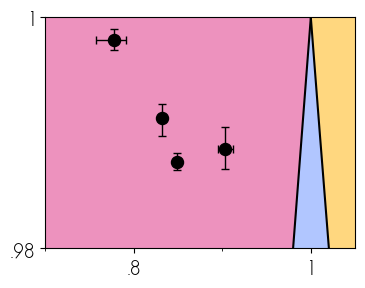

In [30]:
f,ax = plt.subplots(1,1,figsize=(4,3))
example = bootstrapped_res_tot.loc[idx[:,:,:,s]]

ax.fill_between(np.linspace(0,1),np.linspace(0,1),1,facecolor='#dc267f',alpha=0.5,zorder=-2)
ax.fill_between(np.concat([np.linspace(0,1),np.linspace(1,1.5)]),0,np.concatenate([np.linspace(0,1),1/np.linspace(1,1.5)]),facecolor='#648fff',alpha=0.5,zorder=-2)
ax.fill_between(np.linspace(1,1.5),1/np.linspace(1,1.5),1,facecolor='#ffb000',alpha=0.5,zorder=-3)

(_1,caps,_2) = ax.errorbar(example['E[CVx/CVy]'],example['E[rhoxy]'],
             xerr=bsf.CV_bars(example),
             yerr=bsf.rho_bars(example),
             capsize=3,fmt='None',zorder=-2,elinewidth=1,c='k')


ax.scatter(example['E[CVx/CVy]'],example['E[rhoxy]'],
            c='k',s=75)
ax.plot(np.linspace(0,1),np.linspace(0,1),'k-')
ax.plot(np.linspace(1,1.5),1/np.linspace(1,1.5),'k-')

ax.set_xticks([0.8,1])
ax.set_xticks([0.7,0.9,1.1],minor=True)
ax.set_xticklabels(['.8','1'],fontproperties=labelfont)

ax.set_yticks([0.98,1])
ax.set_yticks([0.95],minor=True)
ax.set_yticklabels(['.98','1'],fontproperties=labelfont)

ax.set_xlim(0.7,1.05)
ax.set_ylim(0.98,1)
#f.savefig('figures/July4/andgate_example_rhocv.pdf',bbox_inches='tight')


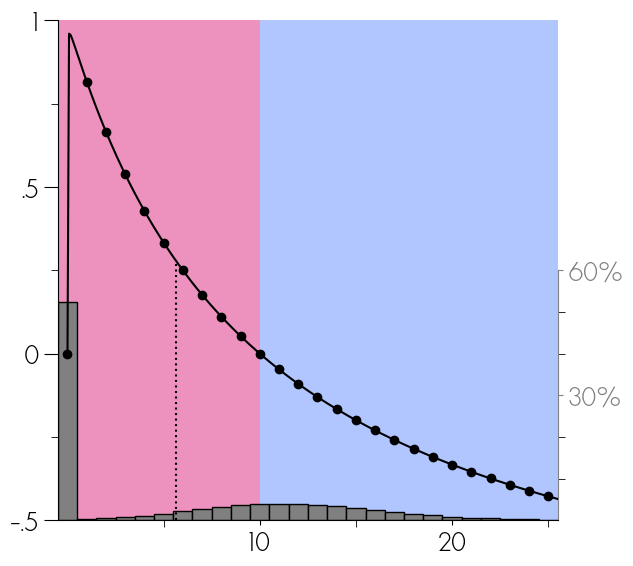

In [31]:
marginal_y = ex.groupby('y')[['p']].sum().reset_index()
pdist = ex
domain = ex['y'].sort_values().unique()[:-1]
contdomain = np.linspace(0,40,500)
avg_y = np.sum(marginal_y['y']*marginal_y['p'])

fig = plt.figure(figsize=(5,5))


ax_pdist = fig.add_axes([0,0,1,0.5],)
ax_pdist.yaxis.tick_right()
ax_pdist.spines['top'].set_visible(False)
ax_pdist.spines['left'].set_visible(False)

ax_pdist.spines['right'].set_color('grey')
ax_pdist.tick_params(axis='y',which='major',color='grey',labelcolor='grey')
ax_pdist.tick_params(axis='y',which='minor',length=5)
ax_pdist.tick_params(axis='x', which='minor',length=5)
ax_pdist.set_xlim(-0.5,25.5)
ax_pdist.set_ylim(0,0.6)


ax_sens = fig.add_axes([0,-0,1,1],facecolor=(0,0,0,0))
ax_sens.yaxis.tick_left()
ax_sens.spines['top'].set_visible(False)
ax_sens.spines['right'].set_visible(False)
ax_sens.spines['bottom'].set_visible(False)
ax_sens.tick_params(axis='x', which='both', labelbottom=False,length=0)
ax_sens.tick_params(axis='y',which='major',length=10)
ax_sens.tick_params(axis='y',which='minor',length=5)
ax_sens.set_xlim(-0.5,25.5)
ax_sens.set_ylim(-0.5,1)
ax_sens.scatter(domain,
         sensitivity(domain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),marker='o',c='k')
ax_sens.plot(contdomain,
            sensitivity(contdomain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),linestyle='-',c='k')

ax_pdist.bar(marginal_y['y'],marginal_y['p'],color='grey',edgecolor='k',
           label=f'perturbation {i}',align='center',width=1)


ax_sens.vlines(avg_y,-0.5,sensitivity(avg_y,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),linestyle=':',color='k')
ax_pdist.fill_between(np.linspace(-0.5,np.sqrt(pars['Kpos'].iloc[0]*pars['Kneg'].iloc[0]),100),
                     -0.5,1.2,facecolor='#dc267f',alpha=0.5,zorder=-10)
ax_pdist.fill_between(np.linspace(np.sqrt(pars['Kpos'].iloc[0]*pars['Kneg'].iloc[0]),25.5,100),
                        -0.5,1.2,facecolor='#648fff',alpha=0.5,zorder=-10)
ax_sens.fill_between(np.linspace(-0.5,np.sqrt(pars['Kpos'].iloc[0]*pars['Kneg'].iloc[0]),100),
                        0.25,1,facecolor='#dc267f',alpha=0.5,zorder=-10)
ax_sens.fill_between(np.linspace(np.sqrt(pars['Kpos'].iloc[0]*pars['Kneg'].iloc[0]),25.5,100),
                        0.25,1,facecolor='#648fff',alpha=0.5,zorder=-10)

ax_sens.set_yticks([-0.5,0,0.5,1])
ax_sens.set_yticks([-0.25,0.25,0.75],minor=True)
ax_sens.set_yticklabels(['-.5','0','.5','1'])

ax_pdist.set_yticks([0.3,0.6])
ax_pdist.set_yticks([0.1,0.2,0.4,0.5],minor=True)
ax_pdist.set_yticklabels([r'30%',r'60%'])

ax_pdist.set_xticks([10,20])
ax_pdist.set_xticks([5,15,20,25],minor=True)
ax_pdist.set_xticklabels([r'10',r'20'])

for tick in ax_pdist.get_xticklabels():
    tick.set_fontproperties(labelfont)
for tick in ax_pdist.get_yticklabels():
    tick.set_fontproperties(labelfont)
for tick in ax_sens.get_yticklabels():
    tick.set_fontproperties(labelfont)

ax_pdist.tick_params(axis='both', which='major', labelsize=20)
ax_sens.tick_params(axis='both', which='major', labelsize=20)

#ax_pdist.set_ylabel('Probability Density',color='grey')
#ax_sens.set_ylabel(r'Sensitivity $1-f_x$',color='k')
ax_pdist.yaxis.set_label_position('right')
#ax_pdist.set_xlabel('mRNA abundance')
#fig.savefig('figures/July4/AndGate_ambiguous_sens_noinset.pdf',bbox_inches='tight')

In [32]:
example['E[<F_y>]']

fileN    fileda   filedb
1.122    0.09441  0.1000   -0.026018
977.200  0.01000  0.3126   -0.048603
10.960   0.09441  0.3126   -0.049126
100.000  0.01000  0.1000   -0.021902
Name: E[<F_y>], dtype: float64

/opt/homebrew/Caskroom/miniforge/base/envs/sci_comp0624/lib/python3.12/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


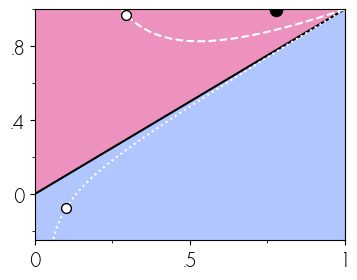

In [33]:
f,ax = plt.subplots(1,1,figsize=(4,3))
example = bootstrapped_res.loc[idx[:,:,:,s]]
sens_at_avg = sensitivity(avg_y,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0])
avg_sens = pertdata.loc[idx[:,:,:,s,:]].groupby('perturbation').mean().iloc[0:3]['<F_y>'].mean()
Ndomain = np.logspace(-4,6,100)
discreteN = example.index.get_level_values('fileN').unique()

ax.fill_between(np.linspace(0,1),np.linspace(0,1),1,facecolor='#dc267f',alpha=0.5,zorder=-2)
ax.fill_between(np.concat([np.linspace(0,1),np.linspace(1,1.5)]),-1,np.concatenate([np.linspace(0,1),1/np.linspace(1,1.5)]),facecolor='#648fff',alpha=0.5,zorder=-2)
ax.fill_between(np.linspace(1,1.5),1/np.linspace(1,1.5),1,facecolor='#ffb000',alpha=0.5,zorder=-3)

(_1,caps,_2) = ax.errorbar(example['E[CVx/CVy]'],example['E[rhoxy]'],
             xerr=bsf.CV_bars(example),
             yerr=bsf.rho_bars(example),
             capsize=1,fmt='None',zorder=-2,elinewidth=0.5,c='k')


ax.scatter(example['E[CVx/CVy]'],example['E[rhoxy]'],
            c='k',s=75)
ax.plot(np.linspace(0,1),np.linspace(0,1),'k-')
ax.plot(np.linspace(1,1.5),1/np.linspace(1,1.5),'k-')
ax.plot(lin_CVratio(1,Ndomain,sens_at_avg,0),lin_rho(1,Ndomain,sens_at_avg,0),c='w',linestyle ='--')
ax.plot(lin_CVratio(1,Ndomain,avg_sens,0),lin_rho(1,Ndomain,avg_sens,0),c='w',linestyle =':')
ax.scatter(lin_CVratio(1,discreteN,sens_at_avg,0),lin_rho(1,discreteN,sens_at_avg,0),c='w',s=50,edgecolors='k',zorder=5)
ax.scatter(lin_CVratio(1,discreteN,avg_sens,0),lin_rho(1,discreteN,avg_sens,0),c='w',s=50,edgecolors='k',zorder=5)


ax.set_yticks([0,0.4,0.8])
ax.set_yticklabels(['0','.4','.8'])
ax.set_yticks([-0.2,0.2,0.6,1],minor=True)
ax.set_ylim(-0.25,1)
ax.set_xlim(0,1.)
ax.set_xticks([0,0.5,1])
ax.set_xticklabels(['0','.5','1'])
ax.set_xticks([0.25,0.75],minor=True)

for tick in ax.get_yticklabels()+ax.get_xticklabels():
    tick.set_fontproperties(labelfont)

#f.savefig('figures/July4/andgate_example_rhocv_twomeasures.pdf',bbox_inches='tight')


In [34]:
fy = sensitivity(ex['y'],pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0])

In [35]:
pars[paramlist].to_clipboard()

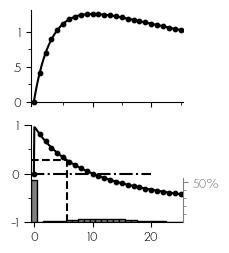

In [36]:
fig,axs = plt.subplots(2,1,figsize=(5/2.54,7/2.54),sharex=True)
marginal_y = ex.groupby('y')[['p']].sum().reset_index()
pdist = ex
domain = ex['y'].sort_values().unique()[:-1]
contdomain = np.linspace(0,40,500)
avg_y = np.sum(marginal_y['y']*marginal_y['p'])
avg_fy = (sensitivity(marginal_y['y'],pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0])*marginal_y['p']).sum()

rate_ax = axs[0]
rate_ax.set_xlim(-0.5,25.5)
rate_ax.plot(contdomain,
      rate(contdomain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),c='k')
rate_ax.scatter(domain,
            rate(domain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),marker='o',c='k',s=10)


ax_sens = axs[1]
new_box = [ax_sens.get_position().bounds[0],ax_sens.get_position().bounds[1],ax_sens.get_position().bounds[2],ax_sens.get_position().bounds[3]/2.2]

ax_pdist = fig.add_axes(new_box, frameon=True,facecolor=(0,0,0,0))
ax_pdist.yaxis.tick_right()
ax_pdist.spines['top'].set_visible(False)
ax_pdist.spines['left'].set_visible(False)
ax_pdist.spines['bottom'].set_visible(False)

ax_pdist.spines['right'].set_color('grey')
ax_pdist.tick_params(axis='y',which='major',color='grey',labelcolor='grey')
ax_pdist.tick_params(axis='y',which='minor',length=2,color='grey')
ax_pdist.set_xlim(-0.5,25.5)
ax_pdist.set_ylim(0,0.55)



ax_sens.yaxis.tick_left()
ax_sens.spines['top'].set_visible(False)
ax_sens.spines['right'].set_visible(False)

ax_sens.tick_params(axis='x', which='both', labelbottom=False,length=0)
ax_sens.tick_params(axis='y',which='major',length=5)
ax_sens.tick_params(axis='y',which='minor',length=2)
ax_sens.set_xlim(-0.5,25.5)
ax_sens.set_ylim(-0.5,1)
ax_sens.scatter(domain,
         sensitivity(domain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),marker='o',c='k',s=10)
ax_sens.plot(contdomain,
            sensitivity(contdomain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),linestyle='-',c='k')

ax_pdist.bar(marginal_y['y'],marginal_y['p'],color='grey',edgecolor='k',
           label=f'perturbation {i}',align='center',width=1)


ax_sens.vlines(avg_y,-1,sensitivity(avg_y,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),linestyle='--',color='k')
ax_sens.hlines(sensitivity(avg_y,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),-0.5,avg_y,linestyle='--',color='k')

ax_sens.hlines(avg_fy,-0.5,20,linestyle='-.',color='k')

ax_sens.set_yticks([-1.,0,1])
ax_sens.set_yticklabels(['-1','0','1'])
ax_sens.set_yticks([-0.5,0.5],minor=True)

ax_pdist.set_yticks([0.5])
ax_pdist.set_yticks([0.1,0.2,0.3,0.4],minor=True)
ax_pdist.set_yticklabels([r'50%'])

rate_ax.set_xticks([10,20])
rate_ax.set_xticks([5,15,20,25],minor=True)
rate_ax.set_xticklabels([r'10',r'20'])

rate_ax.set_yticks([0,0.5,1.])
rate_ax.set_yticks([0.25,0.75],minor=True)
rate_ax.set_yticklabels(['0','.5','1'])
rate_ax.spines['top'].set_visible(False)
rate_ax.spines['right'].set_visible(False)
rate_ax.spines['bottom'].set_position('zero')

for tick in ax_pdist.get_xticklabels():
    tick.set_fontproperties(labelfont)
for tick in ax_pdist.get_yticklabels():
    tick.set_fontproperties(labelfont)
for tick in ax_sens.get_yticklabels():
    tick.set_fontproperties(labelfont)
for tick in rate_ax.get_xticklabels():
    tick.set_fontproperties(labelfont)
for tick in rate_ax.get_yticklabels():
    tick.set_fontproperties(labelfont)

ax_pdist.tick_params(axis='both', which='major', labelsize=10)
ax_sens.tick_params(axis='both', which='major', labelsize=10)
rate_ax.tick_params(axis='both', which='major', labelsize=10)

#ax_pdist.set_ylabel('Probability Density',color='grey')
#ax_sens.set_ylabel(r'Sensitivity $1-f_x$',color='k')
ax_pdist.yaxis.set_label_position('right')
#ax_pdist.set_xlabel('mRNA abundance')
fig.savefig('figures/Nov14/AndGate_joined_rate_sens.pdf',bbox_inches='tight')

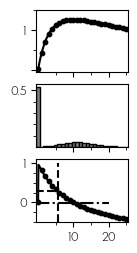

In [37]:
fig,ax = plt.subplots(3,1,figsize=(3/2.54,7/2.54),sharex=True)
ax[0].plot(contdomain,
      rate(contdomain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),c='k')
ax[0].scatter(domain,
            rate(domain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),marker='o',c='k',s=10)

ax[0].set_yticks([0,1])
ax[0].set_yticks([0.5,1.5],minor=True)
ax[0].set_yticklabels(['','1'],fontproperties=labelfont,fontsize=10)


ax[1].bar(marginal_y['y'],marginal_y['p'],color='grey',edgecolor='k',
           label=f'perturbation {i}',align='center',width=1)

ax[1].set_yticks([0.5])
ax[1].set_yticks([0.1,0.2,0.3,0.4],minor=True)
ax[1].set_yticklabels([r'0.5'],fontproperties=labelfont,fontsize=10)

ax[2].scatter(domain,
         sensitivity(domain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),marker='o',c='k',s=10)
ax[2].plot(contdomain,
            sensitivity(contdomain,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),linestyle='-',c='k')
ax[2].vlines(avg_y,-0.5,1,linestyle='--',color='k')
ax[2].hlines(sensitivity(avg_y,pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0]),-0.5,avg_y,linestyle='--',color='k')
ax[2].hlines(avg_fy,-0.5,20,linestyle='-.',color='k')

ax[2].set_ylim(-0.5,1.1)
ax[2].set_yticks([0,1])
ax[2].set_yticklabels(['0','1'],fontproperties=labelfont,fontsize=10)
ax[2].set_yticks([-0.5,-0.25,0.25,0.5,0.75],minor=True)

ax[2].set_xlim(-0.5,25.5)
ax[2].set_xticks([10,20])
ax[2].set_xticks([5,15,20,25],minor=True)
ax[2].set_xticklabels(['10','20'],fontproperties=labelfont,fontsize=10)

fig.savefig('figures/Dec4/AndGate_separated_sensgraph.pdf',bbox_inches='tight')

In [38]:
rate_xp = rate(pdist['y'],pars['Kneg'].iloc[0],pars['Kpos'].iloc[0],pars['lambda'].iloc[0],pars['offset'].iloc[0])
rate_xm = pdist['x']*pars['beta_x'].iloc[0]
rate_yp = pdist['x']*pars['gamma'].iloc[0]
rate_ym = pdist['y']*pars['beta_y'].iloc[0]

In [39]:
delta_x = (rate_xp-rate_xm)*pdist['p']
delta_y = (rate_yp-rate_ym)*pdist['p']
delta_x.index = [pdist['x'],pdist['y']]
delta_y.index = [pdist['x'],pdist['y']]

In [40]:
delta_x.unstack()

y,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
x,,,,,,,,,,,,,,,,,,,,,
0,5.241240e-04,0.000931,0.001819,0.003268,0.005245,0.007563,0.010089,0.012142,0.014027,0.015198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-3.201925e-04,-0.000392,-0.000401,-0.000264,0.000080,0.000635,0.001365,0.002142,0.002849,0.003366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-2.215232e-06,-0.000130,-0.000384,-0.000808,-0.001340,-0.002045,-0.002878,-0.003815,-0.004720,-0.005507,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-6.483448e-08,-0.000016,-0.000094,-0.000288,-0.000591,-0.001113,-0.001793,-0.002703,-0.003613,-0.004448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,-0.000002,-0.000013,-0.000054,-0.000142,-0.000314,-0.000576,-0.000904,-0.001368,-0.001772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
(200-50)/750


0.2

(0.0, 40.0)

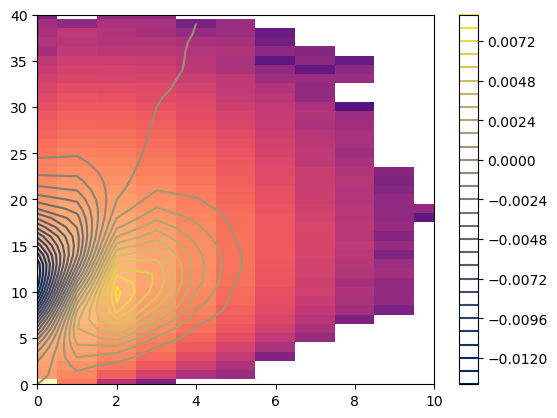

In [42]:
plt.contour(delta_y.unstack().T,
              cmap='cividis',levels=30)
plt.colorbar()
plt.imshow(np.log10(pdist.groupby(['x','y'])['p'].sum().reset_index().pivot(columns='x',index='y',values='p')),
               cmap='magma',aspect='auto')
plt.xlim(0,10)
plt.ylim(0,40)

(0.0, 40.0)

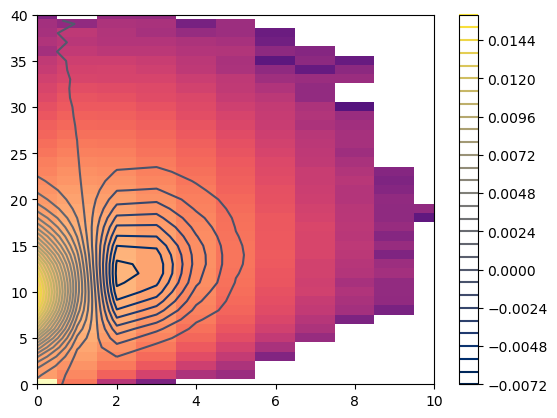

In [43]:
plt.contour(delta_x.unstack().T,
              cmap='cividis',levels=30)
plt.colorbar()
plt.imshow(np.log10(pdist.groupby(['x','y'])['p'].sum().reset_index().pivot(columns='x',index='y',values='p')),
               cmap='magma',aspect='auto')
plt.xlim(0,10)
plt.ylim(0,40)

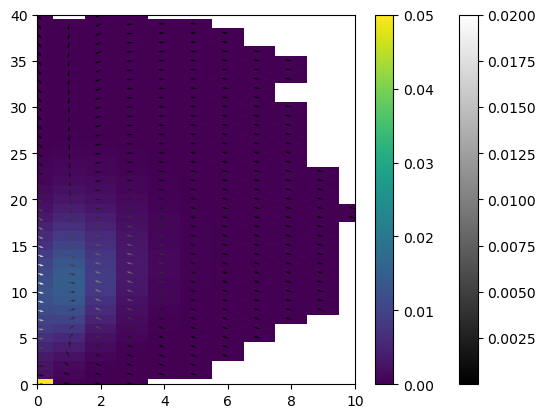

In [44]:
mag = np.sqrt(delta_x**2+delta_y**2)
plt.quiver(pdist['x'],pdist['y'],delta_x/np.sqrt(delta_x**2+delta_y**2),delta_y/np.sqrt(delta_x**2+delta_y**2),np.sqrt(delta_x**2+delta_y**2),angles='xy',cmap='binary_r')
plt.xlim(0,10)
plt.ylim(0,40)
plt.colorbar()
plt.imshow(pdist.groupby(['x','y'])['p'].sum().reset_index().pivot(columns='x',index='y',values='p'),
               cmap='viridis',aspect='auto',vmin=0,vmax=0.05)
plt.colorbar()

In [45]:
curl = np.gradient(delta_y.unstack().T)[1]-np.gradient(delta_x.unstack().T)[0]

(0.0, 40.0)

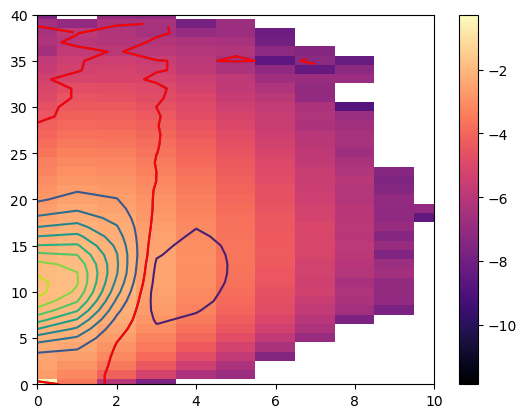

In [46]:
plt.contour(curl,levels=10)
plt.contour(curl,levels=[0],colors='r')

plt.imshow(np.log10(pdist.groupby(['x','y'])['p'].sum().reset_index().pivot(columns='x',index='y',values='p')),
               cmap='magma',aspect='auto')
plt.colorbar()
plt.xlim(0,10)
plt.ylim(0,40)

fileN	lambda	beta_x	gamma	beta_y	Kpos	Kneg	offset
100.0	5.0	1.0	1.0	0.1	10.0	10	0.001
